Evaluation for crnn model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
# === helper functions ===
def levenshtein(a, b):
    dp = np.zeros((len(a)+1, len(b)+1), dtype=np.int32)
    dp[:,0] = np.arange(len(a)+1)
    dp[0,:] = np.arange(len(b)+1)
    for i in range(1, len(a)+1):
        ai = a[i-1]
        for j in range(1, len(b)+1):
            cost = 0 if ai == b[j-1] else 1
            dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1, dp[i-1,j-1]+cost)
    return int(dp[-1,-1])
def levenshtein_ops(ref, hyp):
    n, m = len(ref), len(hyp)
    dp = np.zeros((n+1, m+1), dtype=int)
    dp[:,0] = np.arange(n+1)
    dp[0,:] = np.arange(m+1)
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if ref[i-1] == hyp[j-1] else 1
            dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1, dp[i-1,j-1]+cost)
    ops = []
    i, j = n, m
    while i>0 or j>0:
        if i>0 and dp[i,j]==dp[i-1,j]+1:
            ops.append((ref[i-1], "<del>")); i-=1
        elif j>0 and dp[i,j]==dp[i,j-1]+1:
            ops.append(("<ins>", hyp[j-1])); j-=1
        else:
            ops.append((ref[i-1], hyp[j-1])); i-=1; j-=1
    ops.reverse()
    return ops
def cer(ref, hyp):
    if len(ref) == 0:
        return 0.0 if len(hyp) == 0 else 1.0
    return levenshtein(ref, hyp) / float(len(ref))
def helper(data, pred_texts, true_texts):
    # === collect counts ===
    ALPHABET = "0123456789abcdefghijklmnopqrstuvwxyz"
    true_char_count = Counter()
    pred_char_count = Counter()
    conf = Counter()

    # === per-character accuracy ===
    # correct_count[c] = how many times true=c and pred=c
    total_correct = 0
    correct_count = Counter()
    for ref, hyp in zip(true_texts, pred_texts):
        for r, h in zip(ref, hyp):
            if r == h:
                correct_count[r] += 1
                total_correct += 1


    # accuracy per character = correctly predicted occurrences / true occurrences
    char_acc = {}
    for c in ALPHABET:
        total = true_char_count.get(c, 0)
        char_acc[c] = (correct_count.get(c, 0) / total) if total > 0 else np.nan


    for ref, hyp in tqdm(zip(true_texts, pred_texts), total=len(true_texts)):
        true_char_count.update(ref)
        pred_char_count.update(hyp)
        for r, h in levenshtein_ops(ref, hyp):
            if r != h:
                  conf[(r, h)] += 1

    # === build confusion matrix for heatmap ===
    chars = list(ALPHABET)
    cm = pd.DataFrame(0, index=chars, columns=chars, dtype=int)
    for (r, h), c in conf.items():
        if r in cm.index and h in cm.columns:
            cm.loc[r, h] += c

    plt.figure(figsize=(11, 9))
    mask = cm.values == 0
    sns.heatmap(cm, cmap="rocket_r", square=True, annot=True, fmt="d",
                cbar=True, linewidths=0.5, linecolor="white", mask=mask)
    plt.title("Character Confusion Heatmap (counts)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


    # === enriched top-20 confused pairs with accuracies ===
    print("\nTop 20 confused pairs (with freq + accuracy):")
    header = f"{'True':^6} {'Pred':^6} {'ConfCnt':>8} | {'True_a':>6} {'True_b':>6} {'Pred_a':>6} {'Pred_b':>6} | {'Acc_a':>6} {'Acc_b':>6}"
    print(header)
    print("-"*len(header))

    for (r, h), c in conf.most_common(20):
        true_a = true_char_count.get(r, 0)
        true_b = true_char_count.get(h, 0)
        pred_a = pred_char_count.get(r, 0)
        pred_b = pred_char_count.get(h, 0)
        acc_a  = correct_count.get(r, 0)/true_a if true_a > 0 else np.nan
        acc_b  = correct_count.get(h, 0)/true_b if true_b > 0 else np.nan
        print(f"{r:>6s} {h:<6s} {c:8d} | {true_a:6d} {true_b:6d} {pred_a:6d} {pred_b:6d} | {acc_a:6.3f} {acc_b:6.3f}")

    exact = np.mean([p == t for p, t in zip(pred_texts, true_texts)])
    cer_mean = np.mean([cer(t, p) for p, t in zip(pred_texts, true_texts)])

    print(f"exact-match: {exact*100:.2f}% | CER: {cer_mean:.4f}")
    accuracy = total_correct / sum(true_char_count.values())
    print(f"accuracy: {accuracy*100:.2f}%")

Loaded: 2000 pairs


100%|██████████| 2000/2000 [00:00<00:00, 9819.18it/s] 


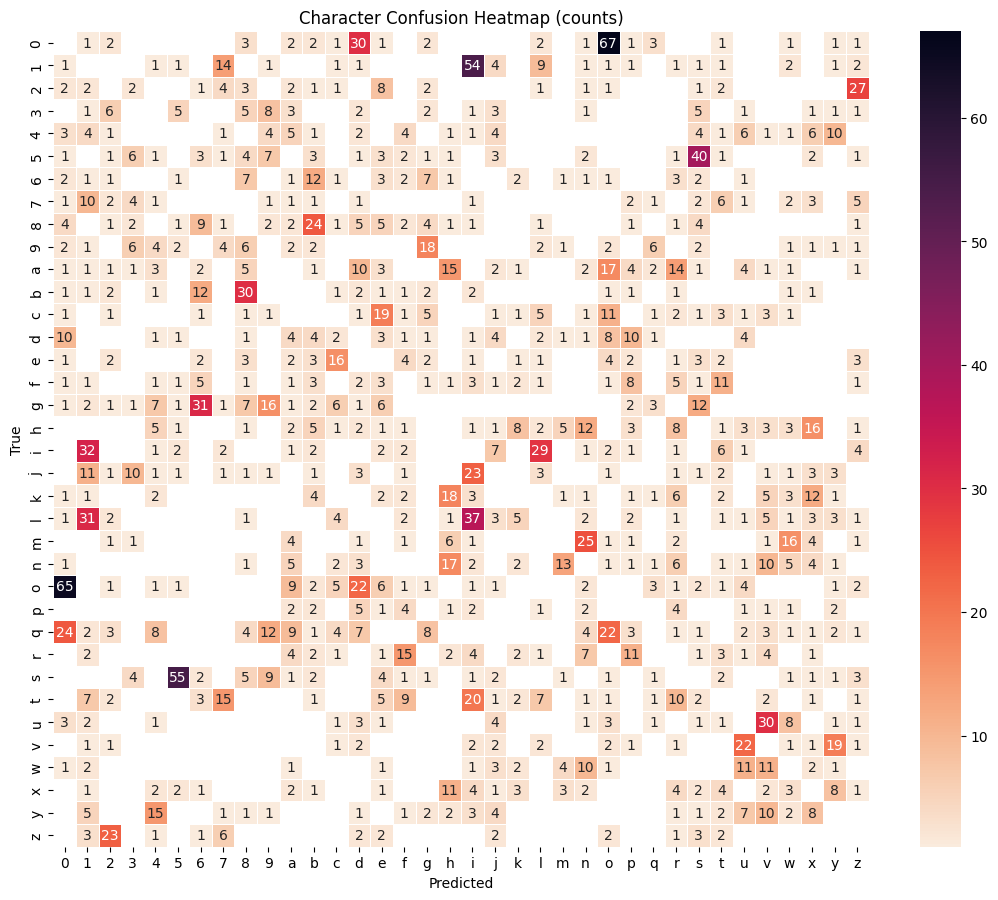


Top 20 confused pairs (with freq + accuracy):
 True   Pred   ConfCnt | True_a True_b Pred_a Pred_b |  Acc_a  Acc_b
--------------------------------------------------------------------
     0 o            67 |    342    348    335    351 |  0.553  0.523
     o 0            65 |    348    342    351    335 |  0.523  0.553
     s 5            55 |    343    319    322    296 |  0.609  0.633
     1 i            54 |    317    353    321    406 |  0.562  0.598
     5 s            40 |    319    343    296    322 |  0.633  0.609
     l i            37 |    356    353    303    406 |  0.601  0.598
     i 1            32 |    353    317    406    321 |  0.598  0.562
     l 1            31 |    356    317    303    321 |  0.601  0.562
     g 6            31 |    324    299    265    312 |  0.571  0.749
     0 d            30 |    342    340    335    381 |  0.553  0.724
     b 8            30 |    323    335    332    340 |  0.700  0.699
     u v            30 |    325    348    322    367 |  

In [ ]:
# === load npz ===
data = np.load("/content/drive/My Drive/CS4243/cs4243-project/preprocessing/clean/hejin_eval_outputs/val_preds_and_truths_3.npz", allow_pickle=True)
pred_texts = data["pred_texts"]
true_texts = data["true_texts"]
print("Loaded:", len(pred_texts), "pairs")
helper(data, pred_texts, true_texts)

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "true": true_texts,
    "pred": pred_texts
})

df["correct"] = df["true"] == df["pred"]
df["cer"] = [levenshtein(t, p) / max(1, len(t)) for t, p in zip(df["true"], df["pred"])]
print(df.head())
print("Accuracy:", df["correct"].mean(), " | Mean CER:", df["cer"].mean())


       true      pred  correct       cer
0    002e23     02e23    False  0.166667
1    03yl9s    o3yi9s    False  0.333333
2   03yuav5   03yuav5     True  0.000000
3    03zl9o    03zl9d    False  0.166667
4  04zqohgi  o4zqoh3l    False  0.375000
Accuracy: 0.2665  | Mean CER: 0.26847738095238094


In [ ]:
CONFUSION_PAIRS = {
    ("o","0"), ("0","o"), ("s","5"), ("5","s"),
    ("i","l"), ("l","i"), ("i","1"), ("1","i"),
    ("1","7"), ("7","1"), ("b","8"), ("8","b"),
    ("g","6"), ("6","g"), ("2","z"), ("z","2"),
    ("v","u"), ("u","v"), ("m","n"), ("n","m"),
    ("h","n"), ("n","h"), ("a","o"), ("o","a"), ("o","d"), ("d","o")
}

def find_confused_pairs(true, pred):
    pairs = []
    for t, p in zip(true, pred):
        if (t, p) in CONFUSION_PAIRS:
            pairs.append(f"{t}->{p}")
    return pairs

df["conf_pairs"] = [find_confused_pairs(t, p) for t, p in zip(df["true"], df["pred"])]
df["has_confusion"] = df["conf_pairs"].apply(bool)
print(df[df["has_confusion"]].head(10))


        true      pred  correct       cer    conf_pairs  has_confusion
1     03yl9s    o3yi9s    False  0.333333  [0->o, l->i]           True
3     03zl9o    03zl9d    False  0.166667        [o->d]           True
4   04zqohgi  o4zqoh3l    False  0.375000  [0->o, i->l]           True
5      05htm     05htn    False  0.200000        [m->n]           True
7       07oj      0x0j    False  0.500000        [o->0]           True
9   08ft2e2z   o8ft2e2    False  0.250000        [0->o]           True
11  08otejfi  08ote3f1    False  0.250000        [i->1]           True
14  0a7sh2wp  oa7sh2np    False  0.250000        [0->o]           True
18   0chnm34    bgnm34    False  0.428571  [h->n, n->m]           True
19    0col7w    0c0l3w    False  0.333333        [o->0]           True


In [ ]:
import string

letters = set(string.ascii_lowercase)
digits = set(string.digits)

def count_stats(text):
    return {
        "len": len(text),
        "n_letters": sum(c in letters for c in text),
        "n_digits": sum(c in digits for c in text),
        "n_hard": sum(c in "o0s5il17b8g6z2mnhvuaod" for c in text)
    }

stats = pd.DataFrame([count_stats(t) for t in df["true"]])
for k in stats.columns:
    df[k] = stats[k]
summary = df.groupby("correct")[["len","n_letters","n_digits","n_hard"]].mean().T
print(summary)


correct       False     True 
len        6.191547  5.491557
n_letters  4.524881  3.994371
n_digits   1.666667  1.497186
n_hard     3.637355  3.153846


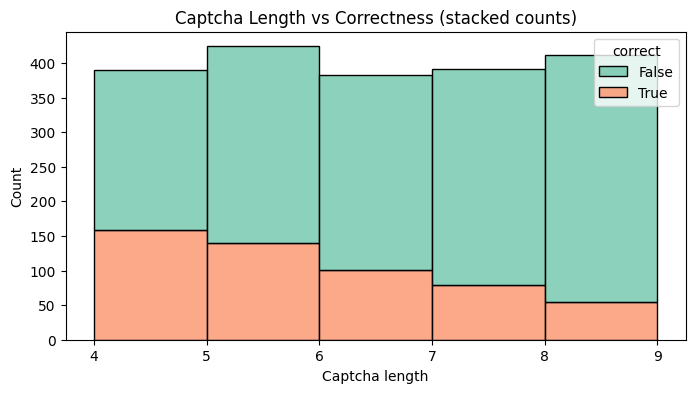

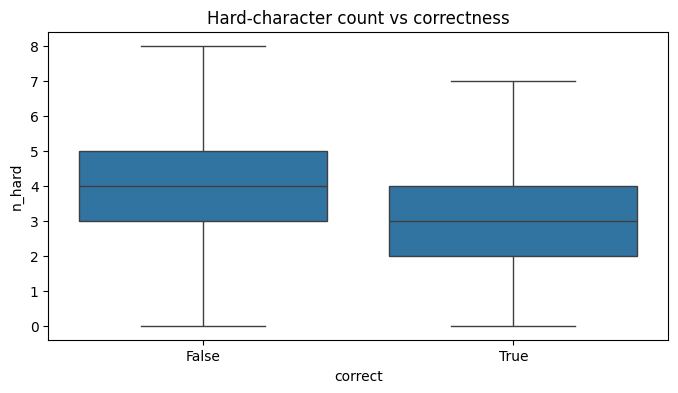

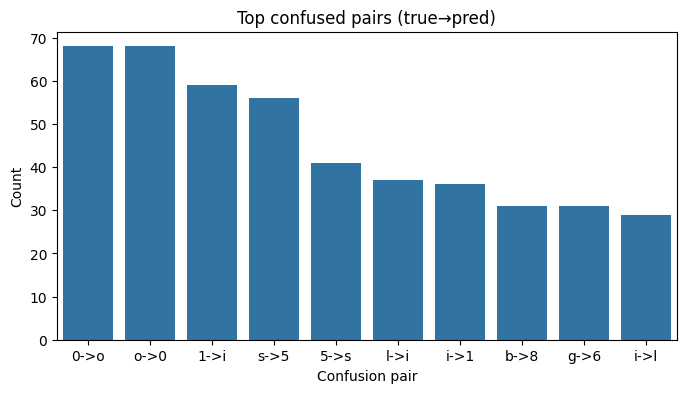

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(data=df, x="len", hue="correct", multiple="stack", palette="Set2", bins=range(df["len"].min(), df["len"].max()+2))
plt.title("Captcha Length vs Correctness (stacked counts)")
plt.xlabel("Captcha length")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="correct", y="n_hard")
plt.title("Hard-character count vs correctness")
plt.show()

conf_counts = pd.Series(sum(df["conf_pairs"], []))
plt.figure(figsize=(8,4))
sns.barplot(x=conf_counts.value_counts().index[:10],
            y=conf_counts.value_counts().values[:10])
plt.title("Top confused pairs (true→pred)")
plt.xlabel("Confusion pair")
plt.ylabel("Count")
plt.show()


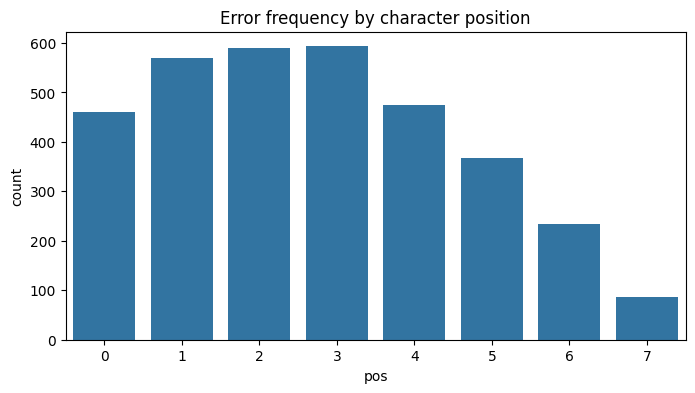

In [ ]:
from collections import Counter
wrong_rows = df[~df["correct"]]

# Which positions in the string cause confusion most often
position_counts = Counter()
for true, pred in zip(wrong_rows["true"], wrong_rows["pred"]):
    for j, (t, p) in enumerate(zip(true, pred)):
        if t != p:
            position_counts[j] += 1

pos_df = pd.DataFrame(list(position_counts.items()), columns=["pos","count"])
plt.figure(figsize=(8,4))
sns.barplot(data=pos_df, x="pos", y="count")
plt.title("Error frequency by character position")
plt.show()
